In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/application_train.csv")

In [5]:
# Count the number of continuous and categorical predictors
continuous_predictors = len(df.select_dtypes(include='number').columns)
categorical_predictors = len(df.select_dtypes(include='object').columns)

# Count the total number of observations
total_observations = len(df)

# Calculate the proportion of 0s and 1s in the 'target' column
target_proportions = df['TARGET'].value_counts(normalize=True)

# Print the results
print("Number of continuous predictors: ", continuous_predictors)
print("Number of categorical predictors: ", categorical_predictors)
print("Total number of observations: ", total_observations)
print("Proportion of 0s and 1s in 'target' column:")
print(target_proportions)

Number of continuous predictors:  106
Number of categorical predictors:  16
Total number of observations:  307511
Proportion of 0s and 1s in 'target' column:
0    0.919271
1    0.080729
Name: TARGET, dtype: float64


In [4]:
# Check for missing values in each predictor
missing_values = df.isnull().sum()
print("Missing Values by Predictor:")
print(missing_values)

# Alternatively, you can also check the percentage of missing values
missing_values_percentage = (df.isnull().sum() / len(df)) * 100
print("Percentage of Missing Values by Predictor:")
print(missing_values_percentage)

Missing Values by Predictor:
SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64
Percentage of Missing Values by Predictor:
SK_ID_CURR                     0.000000
TARGET                         0.000000
NAME_CONTRACT_TYPE             0.000000
CODE_GENDER                    0.000000
FLAG_OWN_CAR                   0.000000
                                ...    
AMT_REQ_CREDIT_BUREAU_DAY     13.501631
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
Length: 122, dtype: float64


### Bagging

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("~/Downloads/application_train.csv")
test_df = pd.read_csv("~/Downloads/application_test.csv")

In [4]:
categorical_features = [col for col in train_df.columns if train_df[col].dtype == 'object']
temp_df = pd.concat([train_df, test_df])
temp_df = pd.get_dummies(temp_df, columns=categorical_features)
train_df = temp_df.iloc[: train_df.shape[0], ]
test_df = temp_df.iloc[train_df.shape[0]:, ]

In [7]:
y = train_df['TARGET']
train_df = train_df.drop('TARGET', axis=1)

In [8]:
import re

final_train_df = train_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
final_test_df = test_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
for column in list(final_train_df.columns[final_train_df.isnull().sum() > 0]):
    mean_val = final_train_df[column].mean()
    final_train_df[column].fillna(mean_val, inplace=True)
    final_test_df[column].fillna(mean_val, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(final_train_df, y, test_size=0.2, random_state=42)

## Bagging

In [9]:
model_bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=42, n_estimators=100),
model_bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
                  random_state=42)

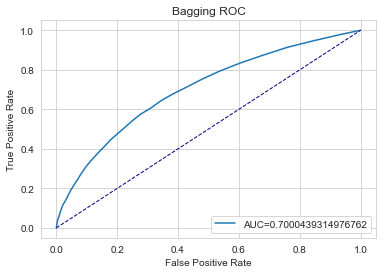

In [10]:
y_pred = model_bagging.predict(X_test)
y_pred_proba = model_bagging.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title("Bagging ROC")
plt.show()

The base model of a bagged decision tree achieves an AUC of ROC curve of 0.71, which is better than the AUC of ROC curve of 0.5 for a random classifier.

## Random Forest

In [11]:
params = {'n_estimators': [100, 150], 'max_depth': [10, 15]}
grid_search_RF = GridSearchCV(RandomForestClassifier(random_state=42),
                              params, scoring=['roc_auc'], refit="roc_auc", cv=3, n_jobs=-1, verbose = True)
grid_search_RF.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 15], 'n_estimators': [100, 150]},
             refit='roc_auc', scoring=['roc_auc'], verbose=True)

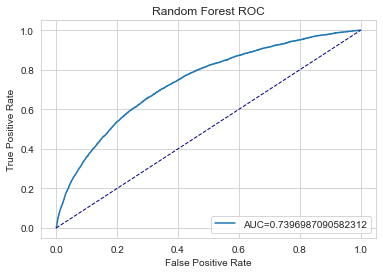

In [12]:
y_pred = grid_search_RF.predict(X_test)
y_pred_proba = grid_search_RF.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title("Random Forest ROC")
plt.show()

The base model of a random forest an AUC of ROC curve of 0.74, which is better than the AUC of ROC of the bagged decision tree above than the 0.5 for a random classifier.